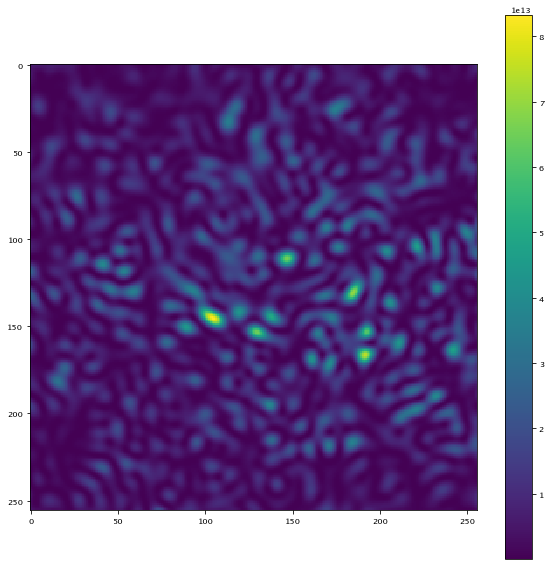

In [5]:
import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

D_tel = 8.2 # meter
wavelength = 500e-9
size_pupil = 128
q, airy = 8, 16
pupil_grid = make_pupil_grid(size_pupil, D_tel)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, q=q, num_airy=airy, wavelength=wavelength)
size_focal = focal_grid.shape[0]
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = circular_aperture(D_tel)(pupil_grid)
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)
wf = Wavefront(aperture, wavelength)
img = (np.abs(prop(layer(wf)).electric_field)**2).reshape(size_focal, size_focal)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()

In [8]:
def center_of_mass(f):
    # takes in a Field, returns its CM.
    # rewriting because there seem to be weird bugs with the scipy inbuilt
    s = f.grid.shape[0]
    x, y = (n.flatten() for n in np.meshgrid(np.linspace(1, s+1, s), np.linspace(1, s+1, s)))
    return np.array((sum(f*x), sum(f*y)))/sum(f)

subgrid = make_pupil_grid(size_focal//2, D_tel/2)
subimages = [img[:size_focal//2, :size_focal//2], img[:size_focal//2, size_focal//2:],
             img[size_focal//2:, :size_focal//2], img[size_focal//2:, size_focal//2:]] 
            # top left, top right, bottom left, bottom right
pixel_CMs = [center_of_mass(Field(quad.flatten(), subgrid)) for quad in subimages]

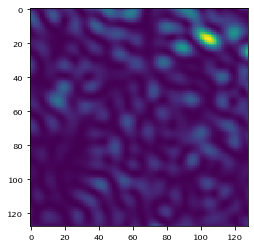